In [1]:
from tamkin import *
from molmod import *

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(-1, '/home/derwer/Desktop/PHD/QM_ThermoKolloq22_multifidelity/')
from tamkintools import *
import matplotlib.pyplot as plt
import numpy
import re
import pandas as pd
# NpT is used when nothing else is specified (1bar)

import os 
from datetime import date

### tetrahydrofuran example utilizing Multi-Fidelity models

- The data are read in, normalized and a multi fidelity model is derived based on the weights. In addition, the periodicity of Rotor Experiments is exploited.
- Afterwards the multi fidelity model can be initialized. This includes the selection of the kernel. There is potential for optimization here. The default RBF kernel oscillates relatively strongly (especially when noise in training data is fixed to small numbers). Therefore in physical applications often Matern kernels are used, since these have smoother samples. Especially when derivatives of functions are to be determined.
- after initialization hyperparameters can be fixed 
- then the model is trained
- after training the high fidelity output is used to overwrite the initial data in the tamkin object
- tamkintools is used with the new data, weights are not necessary anymore




In [2]:
#############
# Constants #
#############
R = 8.3144598
R_a = 8.3144598
kcal = 4.1868 # kJ

data_a = pd.read_csv("first_a.csv",names=["deg","E"]).sort_values('deg')
data_b = pd.read_csv("second_b.csv",names=["deg","E"]).sort_values('deg')
data_c = pd.read_csv("third_c.csv",names=["deg","E"]).sort_values('deg')


data_a['fidelity'] = 0.5
data_b['fidelity'] = 0.5
data_c['fidelity'] = 1

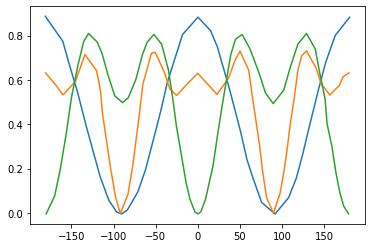

In [3]:
# plot scan data with weights
plt.plot( data_a["deg"],data_a["E"],"-")
plt.plot( data_b["deg"],data_b["E"],"-")
plt.plot( data_c["deg"],data_c["E"],"-")

In [4]:
import numpy as np
np.random.seed(20)
import GPy
import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel


class tamkin_multi_fidelity():
    
    def __init__(self, angles, energies, weights, cmap="winter", 
                 colors=["cornflowerblue","k","magenta"] ):
        """
        initializes the multi fidelity object
        
        angles:   np.array
            angles of a rotor scan
        energies: np.array
            corresponding energies
        weights:  np.array
            based on the weights, fidelities are estimated. Zero weights are excluded.
        cmap: string
            colormap for plots. Default is winter because its snowing outside my office.
        """
        
        self.cmap = cmap
        self.colors = colors
        
        self.msize=12 
        self.fsize=15
        self.alpha=0.3
        self.lsize = 4
        
        self.fidelity_labels = ["low fidelity training data","high fidelity training data"]
        
        # exclude zero weights
        weights  = np.array(weights)
        p = np.where( weights > 0.)
        if len(p) < len(weights):
            print( "zero weights excluded" )
        
        # keep nonzero weights
        self.fidelities = np.array(weights)[p]
        self.angles     = np.array(angles)[p]
        self.energies   = np.array(energies)[p]
        
        # assign fidelities based on weights
        self.unique_weights = np.sort(np.unique(self.fidelities))
        self.no_fidelities = len(self.unique_weights)
        print("number of fidelities:", self.no_fidelities)
        for i,f in enumerate(self.unique_weights):
            self.fidelities[ np.where(self.fidelities==f) ] = i
        print(self.fidelities)
    
        # norm data for stable fits
        self.angle_min    = np.min(self.angles)
        self.angle_range  = np.max(self.angles) - self.angle_min
        self.energy_min   = np.min(self.energies)
        self.energy_range = np.max(self.energies) - self.energy_min
        self.normed_angles   = ( self.angles - self.angle_min )/ self.angle_range
        self.normed_energies = ( self.energies - self.energy_min )/ self.energy_range
        
        # plot normed data and estimated fidelites
        plt.scatter(self.normed_angles, self.normed_energies,c=self.fidelities, cmap=self.cmap)
        plt.xlabel("normalised angles")
        plt.ylabel("normalised energies")
        plt.show()
        plt.close()
        
        # assign periodicity and plot periodic normed data and estimated fidelites
        self.periodic_angles     = np.concatenate((self.normed_angles-1, 
                                                   self.normed_angles, 
                                                   self.normed_angles+1), axis=0)
        self.periodic_energies   = np.tile(self.normed_energies, 3)
        self.periodic_fidelities = np.tile(self.fidelities, 3)
        plt.scatter(self.periodic_angles, self.periodic_energies,c=self.periodic_fidelities, cmap=self.cmap)
        plt.xlabel("periodic normalised angles")
        plt.ylabel("periodic normalised energies")
        plt.show()
        plt.close()
        return
    
    def multi_fidelity(self, kernel=GPy.kern.RBF,n_optimization_restarts=5,dims=1):
        """
        initializes the multi fidelity object
        
        kernel:  GPy.kern
            kernel used in the model (one of the same type for every fidelity)
            the default kernel is the RBF kernel: https://gpy.readthedocs.io/en/deploy/GPy.kern.html
            for physics the behavior of the matern kernel might be better suited than RBF. We need to test this.
            GPy.kern.Matern32 or 52
        n_optimization_restarts: int
            number of optimization restarts with different starting inis
        dims:  int
            dimensions of the multi fidelity model
        """
        Y_train = np.atleast_2d( tmf.periodic_energies ).T
        X_train = np.array( (tmf.periodic_angles, tmf.periodic_fidelities) ).T
        print(X_train.shape)
        print(Y_train.shape)
        #print(X_train)
        #print(Y_train)
        
        kernels = []
        for _ in range(self.no_fidelities):
            kernels.append( kernel(dims) )
        lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
        gpy_lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, 
                                                       n_fidelities=self.no_fidelities)       
        self.lin_mf_model = GPyMultiOutputWrapper(gpy_lin_mf_model, self.no_fidelities, 
                                                  n_optimization_restarts=n_optimization_restarts)
        
    def train(self):
        """
        trains the multi fidelity object.
        
        Adjust and fix hyperparameters and stuff between initialisation and training of the model
        """
        self.lin_mf_model.optimize()    
        return
    
    def predict_hf_normed(self,dummy):
        """
        predicts normed results for a trained multi fidelity model
        
        dummy:  np.array
            normed input data (values between 0 and 1)
            
        returns mean predictions and corresponding standard deviations as np.arrays
        """
        dummy = np.atleast_2d(dummy).T
        X_plot = convert_x_list_to_array([dummy, dummy])
        X_plot_l = X_plot[:len(dummy)]
        X_plot_h = X_plot[len(dummy):]

        hf_mean, hf_var = self.lin_mf_model.predict(X_plot_h)
        hf_std = np.sqrt(hf_var)
        return hf_mean, hf_std

    def predict_hf(self,dummy):
        """
        predicts absolute results for a trained multi fidelity model
        
        dummy:  np.array
            normed input data (values between 0 and 1)
            
        returns absolute inputs, mean predictions and corresponding standard deviations as np.arrays
        """
        hf_mean, hf_std = self.predict_hf_normed(dummy)
        ndummy  = dummy*self.angle_range + self.angle_min
        hf_mean = np.squeeze(hf_mean)
        hf_std  = np.squeeze(hf_std)
        ndummy  = np.squeeze(ndummy)
        return ndummy, hf_mean*self.energy_range + self.energy_min, hf_std*self.energy_range


    def plot_normed_results(self,save=""):
        """
        plots normed rsults of a trained multi fidelity model
        """
        dummy = np.linspace(0,1,100)
        hf_mean, hf_std = self.predict_hf_normed(dummy)
        hf_mean = np.squeeze(hf_mean)
        hf_std = np.squeeze(hf_std)

        plt.plot(dummy, hf_mean,color=self.colors[-1], label="high fidelity prediction",linewidth=self.lsize)
        plt.fill_between(dummy, hf_mean-hf_std, hf_mean+hf_std,alpha=self.alpha,color=self.colors[-1])
        #plt.scatter(self.angles, self.energies,c=self.fidelities, cmap=self.cmap)
        for i,w in enumerate( self.unique_weights ):
            #print(i,w)
            p = np.squeeze( np.where( self.fidelities==i ) )
            plt.plot( self.normed_angles[p], self.normed_energies[p],".", 
                     color=self.colors[i], label=self.fidelity_labels[i],
                    markersize=self.msize)
        plt.xlabel("normalised angles",fontsize=self.fsize)
        plt.ylabel("normalised energies",fontsize=self.fsize)
        plt.xticks(fontsize=self.fsize)     
        plt.yticks(fontsize=self.fsize)     
        plt.legend(fontsize=self.fsize,frameon=False,loc='center left', bbox_to_anchor=(1.01, 0.5))
        if save:
            plt.savefig(save+".png", bbox_inches='tight')
            plt.savefig(save+".pdf", bbox_inches='tight')
        plt.show()
        plt.close()        
        return        
    
    
    def plot_results(self,save=""):
        """
        plots absolute rsults of a trained multi fidelity model
        """
        dummy = np.linspace(0,1,100)
        ndummy, hf_mean, hf_std = self.predict_hf(dummy)

        fig, ax = plt.subplots()
        ax.yaxis.offsetText.set_fontsize(self.fsize)        
        plt.plot(ndummy, hf_mean,color=self.colors[-1], label="high fidelity prediction",linewidth=self.lsize)
        plt.fill_between(ndummy, hf_mean-hf_std, hf_mean+hf_std,alpha=self.alpha,color=self.colors[-1])
        #plt.scatter(self.angles, self.energies,c=self.fidelities, cmap=self.cmap)
        for i,w in enumerate( self.unique_weights ):
            #print(i,w)
            p = np.squeeze( np.where( self.fidelities==i ) )
            plt.plot( self.angles[p], self.energies[p],".", 
                     color=self.colors[i], label=self.fidelity_labels[i],
                    markersize=self.msize)
        plt.xlabel("angles",fontsize=self.fsize)
        plt.ylabel("energies",fontsize=self.fsize)
        plt.xticks(fontsize=self.fsize)     
        plt.yticks(fontsize=self.fsize) 
        plt.ticklabel_format(style='plain')
        plt.legend(fontsize=self.fsize,frameon=False,loc='center left', bbox_to_anchor=(1.01, 0.5))
        if save:
            plt.savefig(save+".png", bbox_inches='tight')
            plt.savefig(save+".pdf", bbox_inches='tight')
        plt.show()
        plt.close()        
        return        


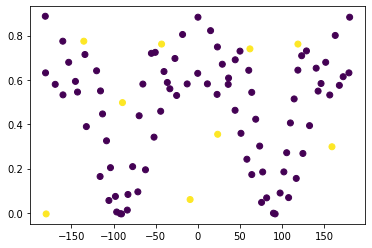

In [6]:
nn=6

a_a = data_a[['deg', 'fidelity']].to_numpy()
a_b = data_b[['deg', 'fidelity']].to_numpy()
a_c = data_c[['deg', 'fidelity']].to_numpy()[::nn,:]

b_a = data_a['E'].to_numpy()
b_b = data_b['E'].to_numpy()
b_c = data_c['E'].to_numpy()[::nn]

a_a = np.concatenate((a_a, a_b), axis=0)
b_a = np.concatenate((b_a, b_b), axis=0)

a = np.concatenate((a_a, a_c), axis=0)
b = np.concatenate((b_a, b_c), axis=0)

plt.scatter( a[:,0],b,c=a[:,1])

zero weights excluded
number of fidelities: 2
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


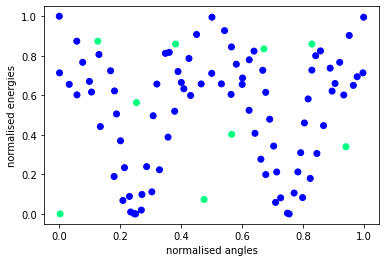

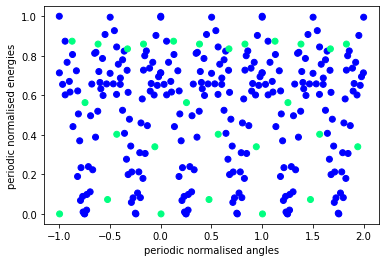

(282, 2)
(282, 1)
Optimization restart 1/5, f = -25.785524765155287
Optimization restart 2/5, f = -25.785524766581574
Optimization restart 3/5, f = -25.78552474841456
Optimization restart 4/5, f = -25.785524764597085
Optimization restart 5/5, f = -25.78552476646493


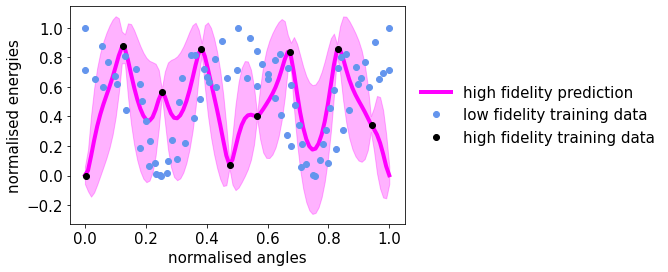

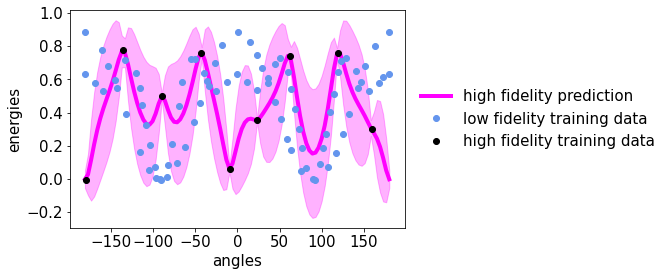

In [9]:


# initialize tamkin multi fidelity
tmf = tamkin_multi_fidelity( a[:,0], b, a[:,1])
# initialize multi fidelity model
# the default kernel is the RBF Kernel.
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
#tmf.multi_fidelity()
tmf.multi_fidelity(kernel=GPy.kern.Matern32)

# adjust hyperparameters and so on before model is trained
#tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise.fix(0.001)
tmf.lin_mf_model.gpy_model.mixed_noise.Gaussian_noise_1.fix(0.0000001)

# train multi fidelity model
tmf.train()
#plot results
tmf.plot_normed_results("normalised_multi_fidelity_playground")
tmf.plot_results("multi_fidelity_playground")


# predict values for initial datapoints
normed_angles = np.sort(tmf.normed_angles)
mf_angles, mf_energy, mf_std = tmf.predict_hf(normed_angles)

tmf.lin_mf_model.gpy_model


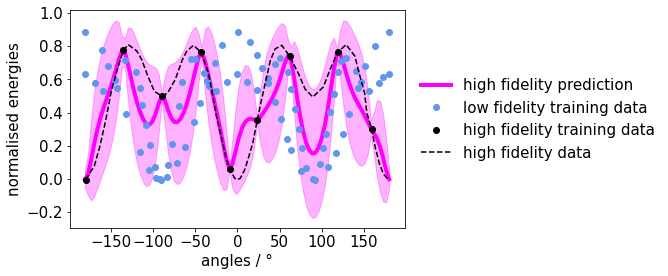

In [10]:
save = "multi_fidelity_plus_playground"

dummy = np.linspace(0,1,100)
ndummy, hf_mean, hf_std = tmf.predict_hf(dummy)


plt.plot(ndummy, hf_mean,color=tmf.colors[-1], label="high fidelity prediction",linewidth=tmf.lsize)
plt.fill_between(ndummy, hf_mean-hf_std, hf_mean+hf_std,alpha=tmf.alpha,color=tmf.colors[-1])

#plt.scatter(self.angles, self.energies,c=self.fidelities, cmap=self.cmap)
for i,w in enumerate( tmf.unique_weights ):
    #print(i,w)
    p = np.squeeze( np.where( tmf.fidelities==i ) )
    plt.plot( tmf.angles[p], tmf.energies[p],".", 
             color=tmf.colors[i], label=tmf.fidelity_labels[i],
            markersize=tmf.msize)

plt.plot(data_c['deg'].to_numpy(),data_c['E'].to_numpy(),"k--", label="high fidelity data")
    
plt.xlabel("angles / °",fontsize=tmf.fsize)
plt.ylabel("normalised energies",fontsize=tmf.fsize)
plt.xticks(fontsize=tmf.fsize)     
plt.yticks(fontsize=tmf.fsize)     
plt.legend(fontsize=tmf.fsize,frameon=False,loc='center left', bbox_to_anchor=(1.01, 0.5))
if save:
    plt.savefig(save+".png", bbox_inches='tight')
    plt.savefig(save+".pdf", bbox_inches='tight')
plt.show()
plt.close()        
